# [GD3]Object Detection
## Go/Stop Object Detection 

1. 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.
2. Object detection 모델을 학습할 수 있습니다.
3. Detection 모델을 활용한 시스템을 만들 수 있습니다.

4. 자율주행 보조장치
5. RetinaNet
6. keras-retinanet
7. 프로젝트: 자율주행 보조 시스템 만들기 Go/Stop

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

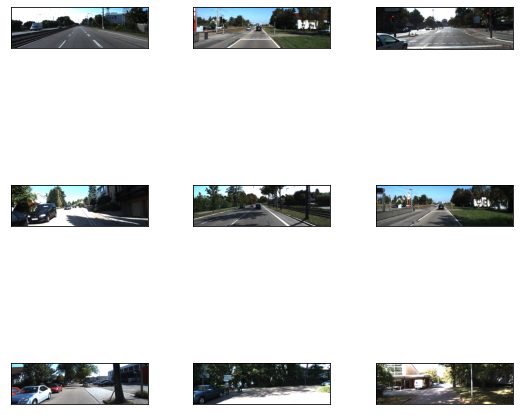

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

데이터 직접 확인하기

In [5]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 2.21,  1.87,  1.91,  1.83, -1.29], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.28776   , 0.27582932],
       [0.28112   , 0.34268117, 0.5114933 , 0.45289856],
       [0.36208   , 0.42539454, 0.52066666, 0.49668276],
       [0.40597335, 0.48729467, 0.52085334, 0.5390821 ],
       [0.49637333, 0.64717394, 0.56498665, 0.68178743]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.96, 1.81, 2.58],
       [1.51, 1.63, 4.03],
       [1.57, 1.44, 3.6 ],
       [1.47, 1.51, 3.5 ],
       [1.77, 1.75, 4.67]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.41,  1.79,  5.13],
       [-2.26,  1.74, 14.92],
       [-1.04,  1.79, 21.1 ],
       [ 1.04,  1.73, 26.57],
       [15.59,  1.12, 52.14]], dtype=float32)>, 'oc

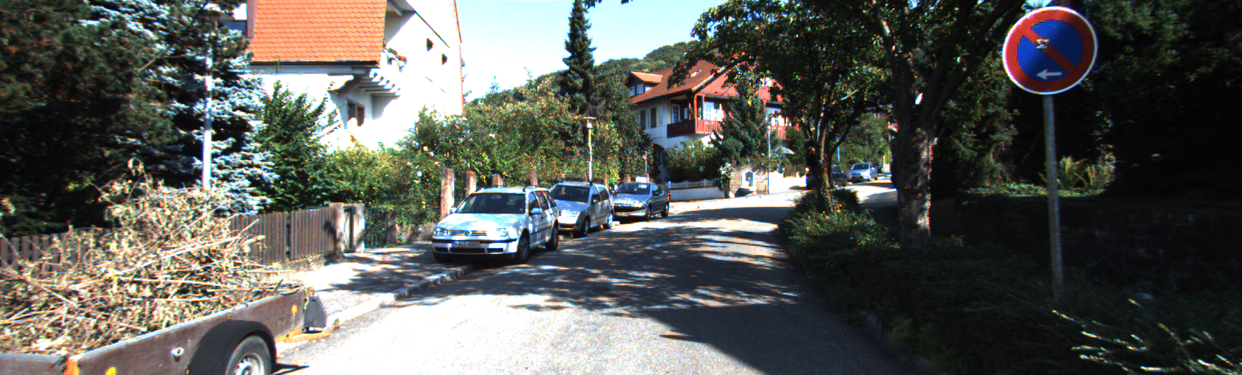

In [6]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(5, 4)
[  0.      374.      342.58002 267.09   ]
[425.61002 269.58002 562.5     183.19   ]
[528.34 239.22 616.88 179.75]
[605.22 222.76 669.54 179.68]
[803.79004 188.86    846.77997 163.13   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F2F807DFCD0>


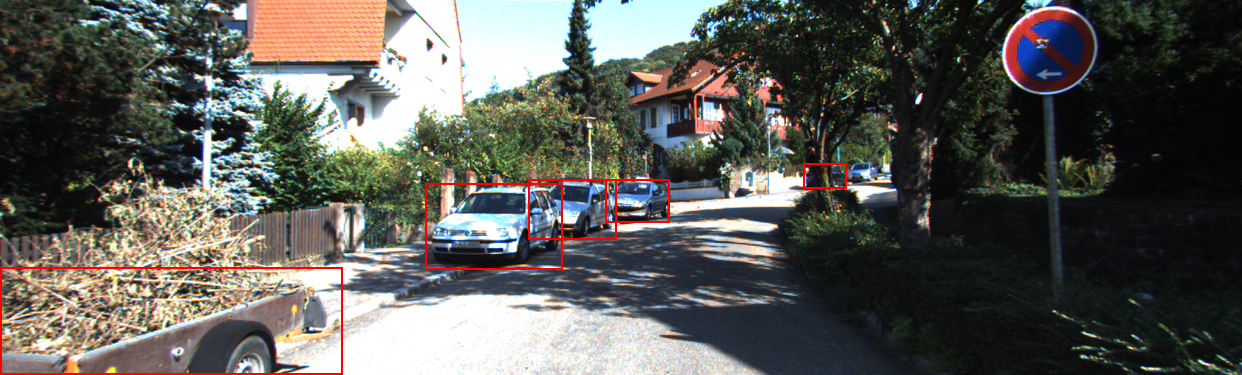

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())


keras-retinanet 실습 (1) 데이터 포맷 변경

In [8]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:20<00:00,  7.92it/s]


In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:34<00:00,  7.54it/s]


클래스 맵핑
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.



In [10]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

keras-retinanet 실습 (2) 셋팅


In [11]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-26 09:15:33.869698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 09:15:35.243060: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 09:15:35.245366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 09:15:35.269059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 09:15:35.269453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-26 09:15:35.269470: I tensorflow/stream_executor/platform/default/d

res5a_branch2c (Conv2D)         (None, None, None, 2 1048576     res5a_branch2b_relu[0][0]        
__________________________________________________________________________________________________
res5a_branch1 (Conv2D)          (None, None, None, 2 2097152     res4f_relu[0][0]                 
__________________________________________________________________________________________________
bn5a_branch2c (BatchNormalizati (None, None, None, 2 8192        res5a_branch2c[0][0]             
__________________________________________________________________________________________________
bn5a_branch1 (BatchNormalizatio (None, None, None, 2 8192        res5a_branch1[0][0]              
__________________________________________________________________________________________________
res5a (Add)                     (None, None, None, 2 0           bn5a_branch2c[0][0]              
                                                                 bn5a_branch1[0][0]               
__________

2021-04-26 09:15:38.865462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-26 09:15:38.865945: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-26 09:15:44.800978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-26 09:15:45.850407: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-26 09:15:45.879584: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-26 09:15:46.137074: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
195/195 [===========================

195/195 [==============================] - 56s 284ms/step - loss: 1.1563 - regression_loss: 0.8971 - classification_loss: 0.2592

Epoch 00018: saving model to ./snapshots/resnet50_csv_18.h5
Epoch 19/50
195/195 [==============================] - 56s 284ms/step - loss: 1.2282 - regression_loss: 0.9560 - classification_loss: 0.2721

Epoch 00019: saving model to ./snapshots/resnet50_csv_19.h5
Epoch 20/50
195/195 [==============================] - 56s 284ms/step - loss: 1.2534 - regression_loss: 0.9773 - classification_loss: 0.2761

Epoch 00020: saving model to ./snapshots/resnet50_csv_20.h5

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 21/50
195/195 [==============================] - 56s 284ms/step - loss: 1.2888 - regression_loss: 1.0040 - classification_loss: 0.2848

Epoch 00021: saving model to ./snapshots/resnet50_csv_21.h5
Epoch 22/50
195/195 [==============================] - 56s 284ms/step - loss: 1.1621 - regression_loss: 0.9042 - classifica

195/195 [==============================] - 56s 285ms/step - loss: 1.0795 - regression_loss: 0.8299 - classification_loss: 0.2496

Epoch 00039: saving model to ./snapshots/resnet50_csv_39.h5

Epoch 00039: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
Epoch 40/50
195/195 [==============================] - 56s 285ms/step - loss: 1.0803 - regression_loss: 0.8252 - classification_loss: 0.2551

Epoch 00040: saving model to ./snapshots/resnet50_csv_40.h5
Epoch 41/50
195/195 [==============================] - 56s 285ms/step - loss: 1.1962 - regression_loss: 0.9171 - classification_loss: 0.2791

Epoch 00041: saving model to ./snapshots/resnet50_csv_41.h5
Epoch 42/50
195/195 [==============================] - 56s 285ms/step - loss: 1.1497 - regression_loss: 0.8866 - classification_loss: 0.2631

Epoch 00042: saving model to ./snapshots/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
Epoch 43/50
195/195 [======================

In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-26 10:03:28.403020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 10:03:29.853896: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 10:03:29.854419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 10:03:29.877161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 10:03:29.877574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-26 10:03:29.877593: I tensorflow/stream_executor/platform/default/d

keras-retinanet 실습 (3) 시각화

In [21]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('./object_detection/', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.57086 176.34322 625.0916  205.7766 ]
[194.06447 133.83696 332.57132 232.06665]
[583.36    175.49522 612.4246  205.98764]


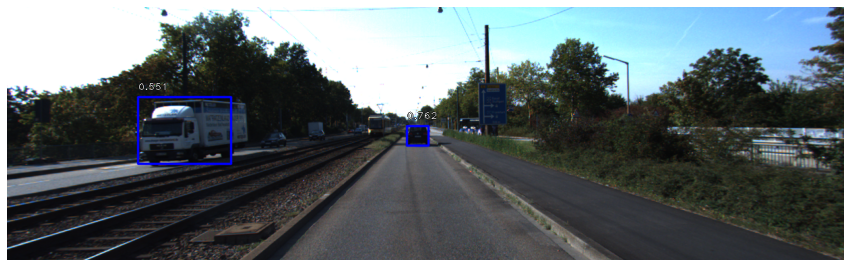

In [22]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[773.4306  147.44804 842.4518  314.8487 ]
[772.20905 147.7042  848.5575  311.4266 ]


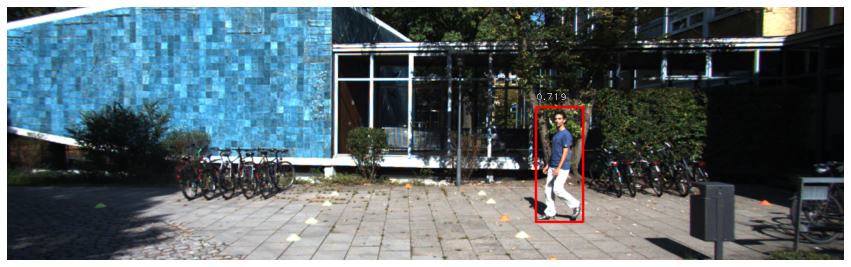

In [23]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

자율주행 보조 시스템 만들기

In [56]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_4.png'

def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
        
        #사람이 한 명 이상 있는 경우
        #차량의 크기(width or height)가 300px이상인 경우
        
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    count = 0
    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            #print(box)
            width = box[2] - box[0]
            height = box[3] - box[1]
            #print(width, height)
            #print(label)
                        
            if label==1 :
                count = count + 1
                if count >= 1:
                    return "Stop"
            else :
                if (width>300 or height>300) and (label==0) :
                    return "Stop"
                else :
                    return "Go"
            
            
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        #plt.figure(figsize=(15, 15))
        #plt.axis('off')
        #plt.imshow(draw)
        #plt.show()       
        
    

#inference_on_image(model, img_path=img_path)
        
        

self_drive_assist(model, img_path=img_path)


'Stop'

자율주행 시스템 평가하기

In [57]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(model, image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


## Result

1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.
바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.
테스트 수행결과 90% 이상의 정확도를 보였다.

            if label==1 :
                count = count + 1
                if count >= 1:
                    return "Stop"
            else :
                if (width>300 or height>300) and (label==0) :
                    return "Stop"
                else :
                    return "Go"